In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score

try:
    import deap
except:
    !pip install deap
    import deap

try: 
    import mobopt
except:
    !pip install https://github.com/ppgaluzio/MOBOpt/archive/master.zip
    import mobopt

import warnings

warnings.filterwarnings("ignore")

In [2]:
cancer = load_breast_cancer()
X = cancer["data"]
y = cancer["target"]

print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 123)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

(569, 30) (569,)
(426, 30) (143, 30) (426,) (143,)


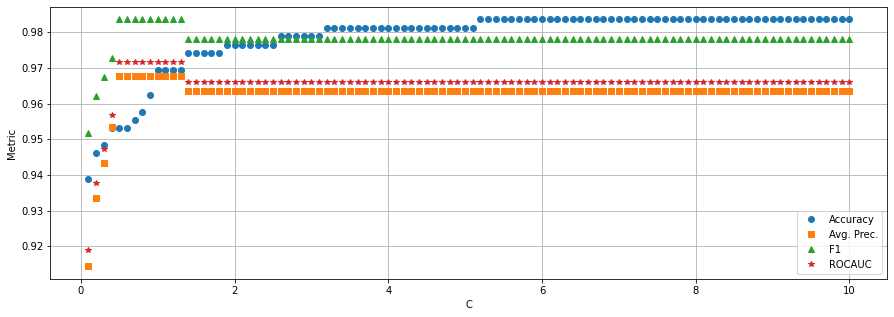

In [3]:
def objective_function(C):
    model = LogisticRegression(C = C[0])
    model.fit(X_train_scaled, y_train)
    accuracy = model.score(X_train_scaled, y_train)
    average_precision = average_precision_score(y_test, model.predict(X_test_scaled))
    f1 = f1_score(y_test, model.predict(X_test_scaled))
    rocauc = roc_auc_score(y_test, model.predict(X_test_scaled))
    return np.array([accuracy, average_precision, f1, rocauc])

C = np.arange(0.1, 10+0.1, 0.1).reshape(-1, 1)
scores = []
for i in range(len(C)):
    scores.append(objective_function(C[i]))
scores = np.array(scores)

plt.figure(figsize = (15, 5))
plt.plot(C, scores[:, 0], "o")
plt.plot(C, scores[:, 1], "s")
plt.plot(C, scores[:, 2], "^")
plt.plot(C, scores[:, 3], "*")
plt.xlabel("C")
plt.ylabel("Metric")
plt.legend(["Accuracy", "Avg. Prec.", "F1", "ROCAUC"])
plt.grid(True)

In [4]:
optimizer = mobopt.MOBayesianOpt(target = objective_function, # objective function to optimize
                                 NObj = 4, # number of dimensions in the objective space
                                 pbounds = np.asarray([[0.1, 10.0]]), # boundaries of the search space C
                                 verbose = False, # print out iteration details or not
                                 max_or_min = "max") # minimize or maximize the objective function

# Initialize with 10 of random walks to gather data points
optimizer.initialize(init_points = 10)

# Optimize the multi-objective function
front, pop = optimizer.maximize(n_iter = 50) 

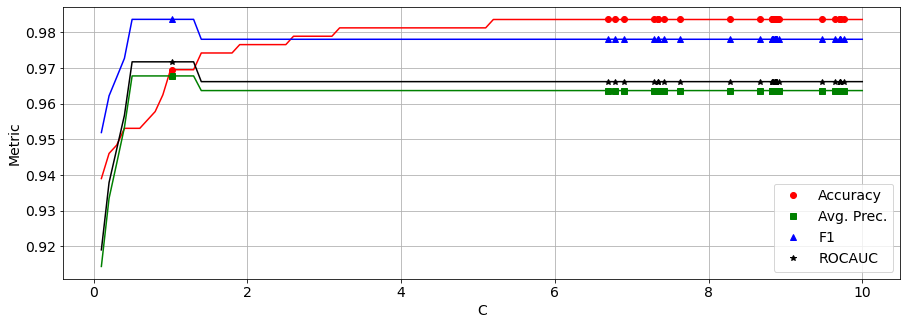

In [5]:
PF = optimizer.y_Pareto.copy() # list of non-dominated sampled points in objective space
PS = optimizer.x_Pareto.copy() # list of non-dominated sampled points in search space

plt.figure(figsize = (15, 5))
plt.plot(PS, PF[:, 0], "ro")
plt.plot(PS, PF[:, 1], "gs")
plt.plot(PS, PF[:, 2], "b^")
plt.plot(PS, PF[:, 3], "k*")
plt.xlabel("C", fontsize = 14)
plt.ylabel("Metric", fontsize = 14)
plt.legend(["Accuracy", "Avg. Prec.", "F1", "ROCAUC"], fontsize = 14)
plt.plot(C, scores[:, 0], "r")
plt.plot(C, scores[:, 1], "g")
plt.plot(C, scores[:, 2], "b")
plt.plot(C, scores[:, 3], "k")
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(True)